<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [427]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from math import sqrt
import patsy

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [428]:
# Loading the housing data into a DataFrame
house = pd.read_csv('./housing.csv')

In [429]:
# Checking the head of the dataframe
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [430]:
# Checking the column names in the dataframe
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [431]:
# Checking data types of column names
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [432]:
# Printing house dataframe
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [433]:
#Splitting all the columns into fixed and renovatable features
fixed = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 
                 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
                 'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinSF1', 
                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
                 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 
                 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 
                 'SaleType', 'SalePrice']

fixed_minus = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 
                 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
                 'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinSF1', 
                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
                 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 
                 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 
                 'SaleType', 'SalePrice']

reno = ['OverallQual', 'ExterQual', 'BsmtQual', 'LowQualFinSF', 'KitchenQual', 'GarageQual', 'OverallCond', 
                 'ExterCond', 'GarageCond', 'BsmtCond', 'SaleCondition', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                 'Heating', 'HeatingQC', 'Electrical', 'PoolQC', 'BsmtFinType2', 'BsmtFinType1', 'FireplaceQu', 'GarageFinish',
                 'PavedDrive', 'Fence', 'SalePrice']

#house_f = house[fixed]
#house_r = house[reno]
#house_f

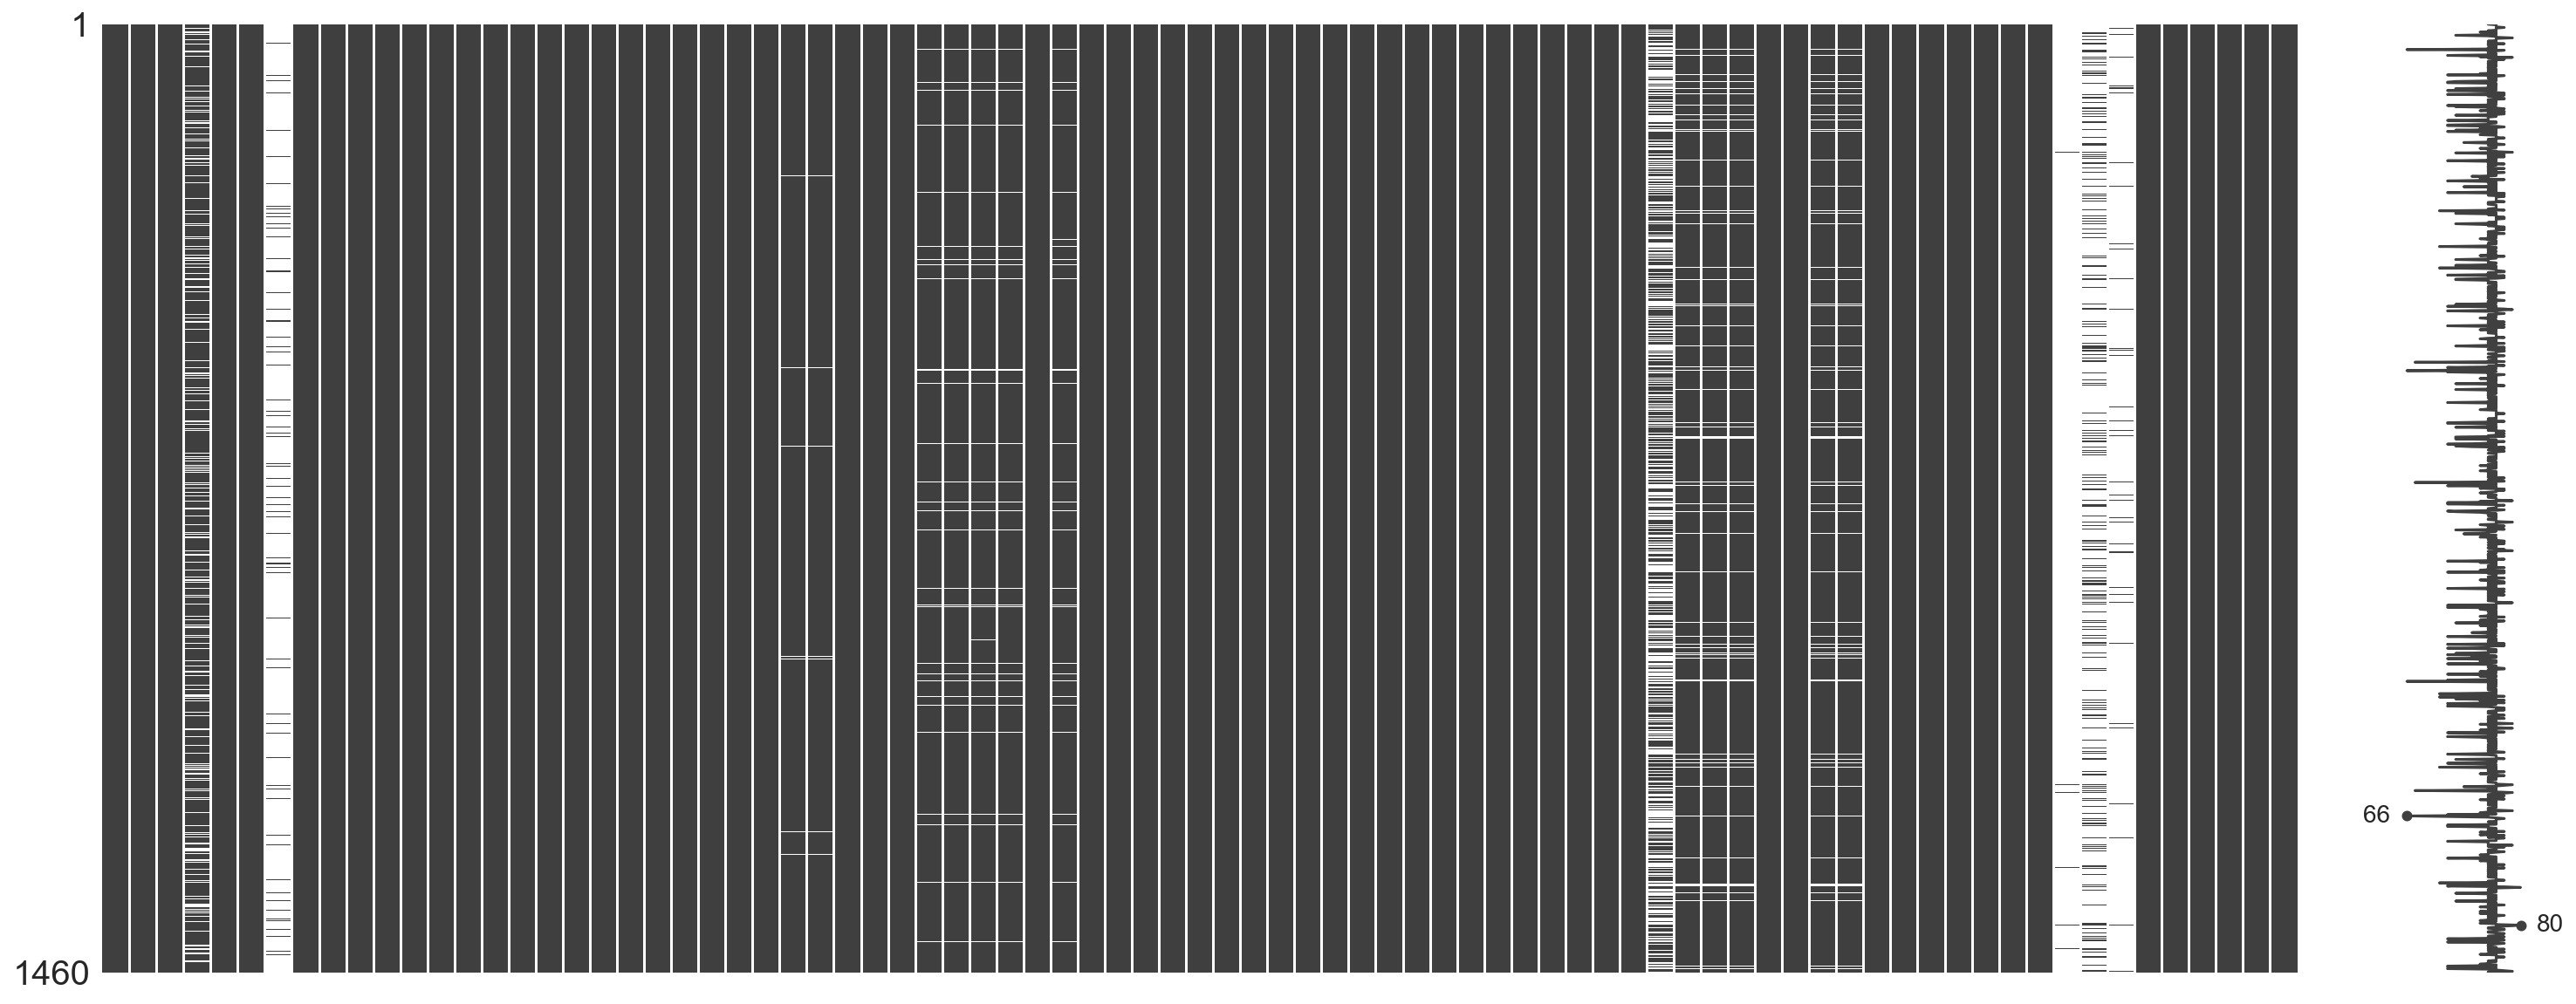

In [434]:
# Checking for column density in the house dataframe
msno.matrix(house)

In [435]:
# Removing rows of non-residential properties in both dataframes
house_res = house[house.MSZoning != 'A']
house_res = house_res[house_res.MSZoning != 'C (all)']
house_res = house_res[house_res.MSZoning != 'I']

house_res.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [436]:
# Deleting Alley and Misc Features columns as they mostly have NaNs
house_res_c = house_res.drop(['Alley','MiscFeature'], axis=1)
house_res_c.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,0,12,2008,WD,Normal,250000


In [437]:
# Dropping all rows with NaNs in them. Now the house_res_clean is our clean dataset
house_res_clean_0 = house_res_c.dropna(subset = fixed_minus)
house_res_clean = house_res_clean_0[house_res_clean_0.columns.intersection(fixed_minus)]
house_res_clean_0 = house_res_clean_0.drop('Id', axis=1)
house_res_clean = house_res_clean.drop('Id', axis=1)
house_res_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,250000


In [440]:
# Function to create the formula for Patsy
def ols_formula(df, dependent_var, *excluded_cols):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    for col in excluded_cols:
        df_columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(df_columns)


In [463]:
# Testing a linear regression model on the complete dataframe with all fixed features
formula = ols_formula(house_res_clean, 'SalePrice')
formula1 = 'SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street + LotShape + LandContour + Utilities + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + YearBuilt + YearRemodAdd + MasVnrType + MasVnrArea + Foundation + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + CentralAir + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Functional + Fireplaces + GarageType + GarageYrBlt + GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ScreenPorch + PoolArea + MiscVal + MoSold + YrSold + SaleType - 1'
#formula1 = 'SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street + LotShape + LandContour + Utilities + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + YearBuilt + YearRemodAdd + MasVnrType + MasVnrArea + Foundation + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + CentralAir + 1stFlrSF + 2ndFlrSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Functional + Fireplaces + GarageType + GarageYrBlt + GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch + PoolArea + MiscVal + MoSold + YrSold + SaleType'
t, M = patsy.dmatrices(formula1, data=house_res_clean, return_type='dataframe')
df = pd.concat([M, t], axis=1)

# # Splitting the dataset into traning and testing datasets
train = df[df['YrSold'] != 2010]
train_X = train.drop(['SalePrice'], axis=1) 
train_y = train.SalePrice
test = df[df['YrSold'] == 2010]
test_X = test.drop(['SalePrice'], axis=1) 
test_y = test.SalePrice

#print(train.shape, train_X.shape, train_y.shape, test.shape, test_X.shape, test_y.shape)

linear = sm.OLS(train_y, train_X).fit()
linear.summary()

pred_y = linear.predict(test_X)
np.sqrt(mean_squared_error(test_y, pred_y))

29894.92205508699

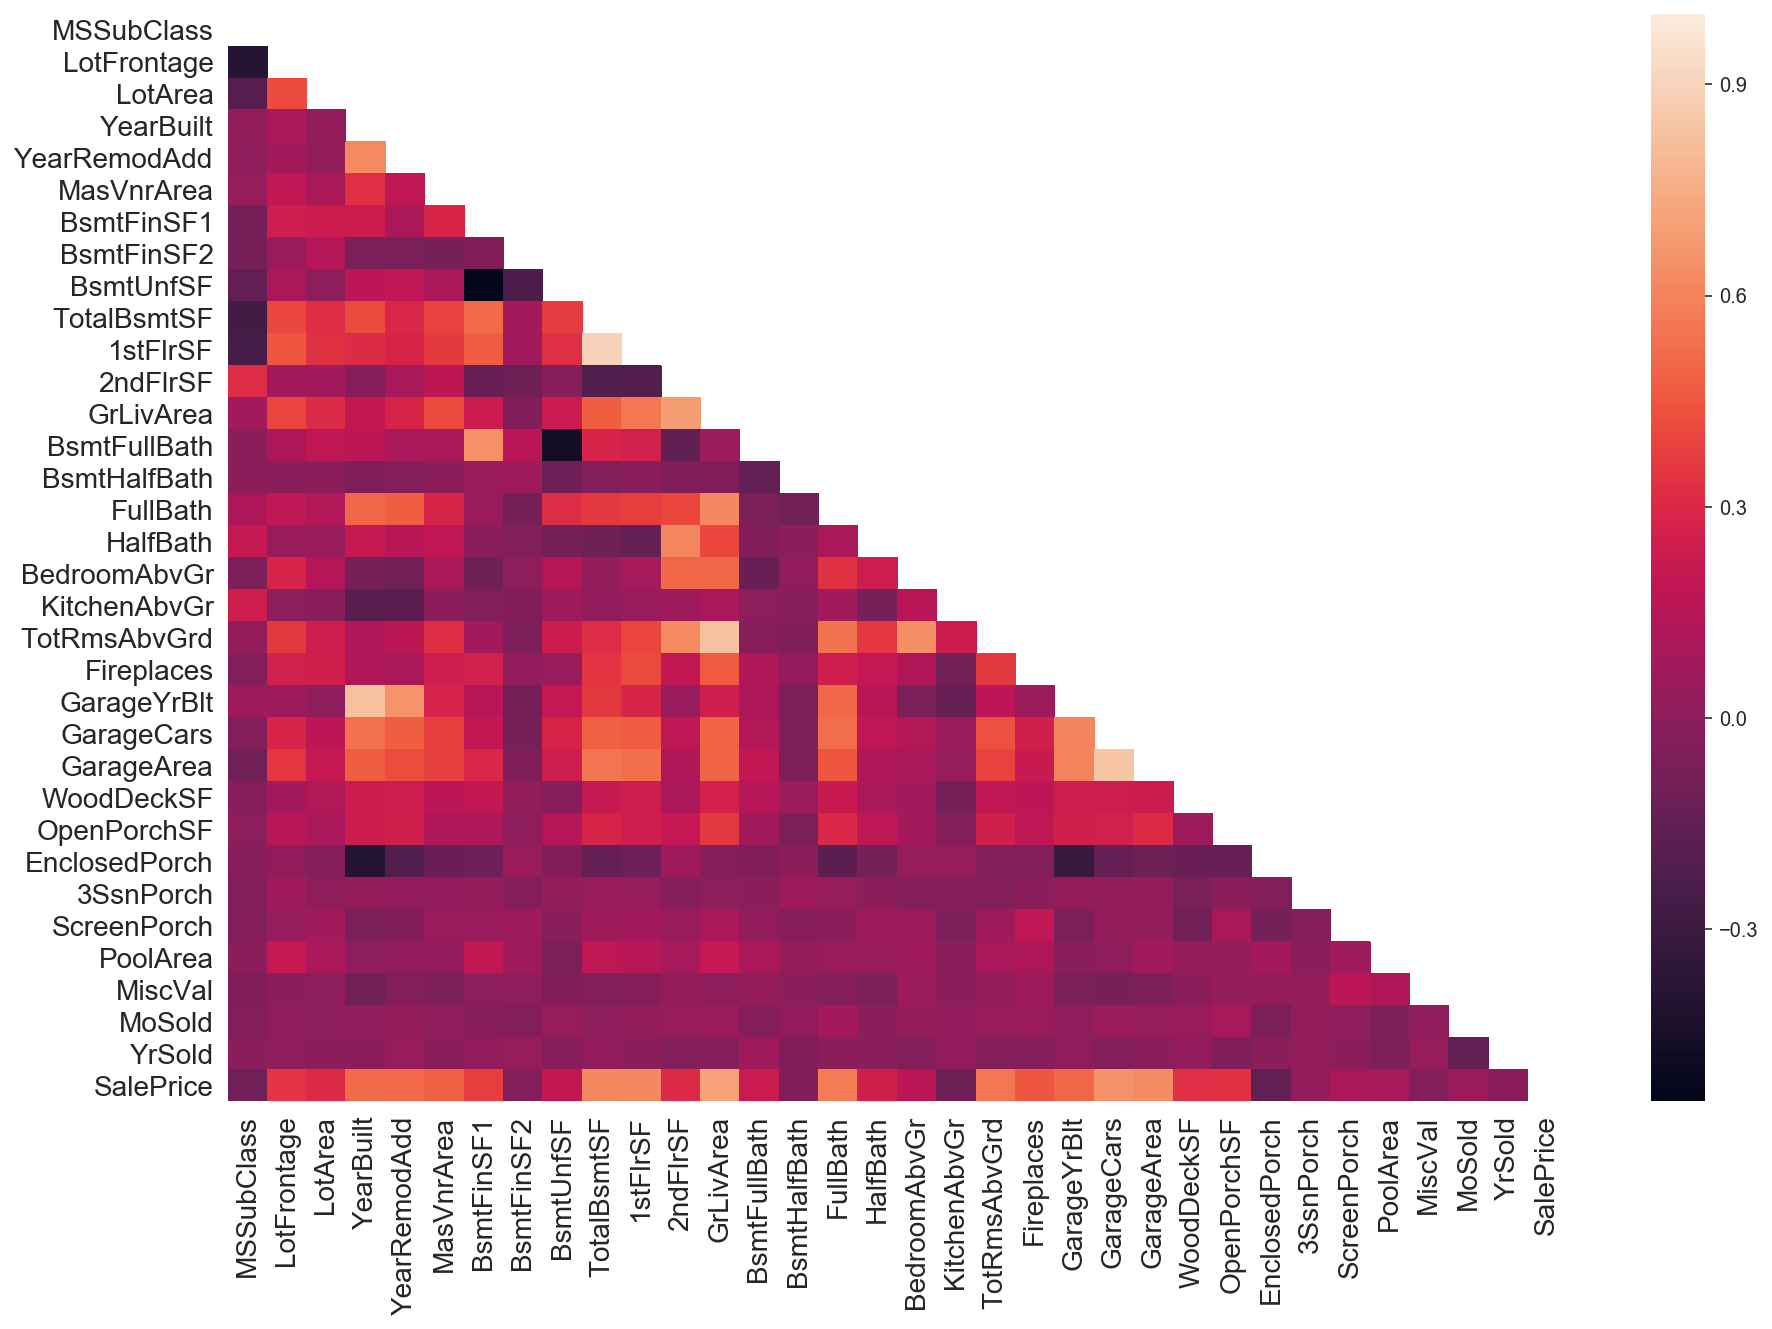

In [331]:
# Checking for multi-collinearity among features in the Dataframe
# Heat map of all numerical columns to understand the correlation among variables

mean_corr = house_res_clean.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(15,10))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

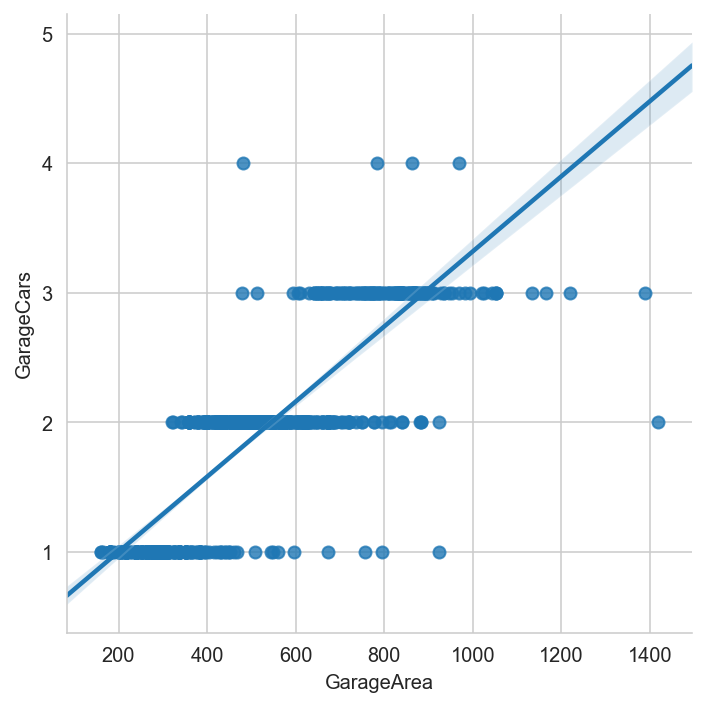

In [332]:
# Exploring correlation among Garage Area and Garage Cars. One of the variables can be removed to avoid multi-collinearity.
sns.lmplot(x='GarageArea',y='GarageCars',data=house_res_clean)

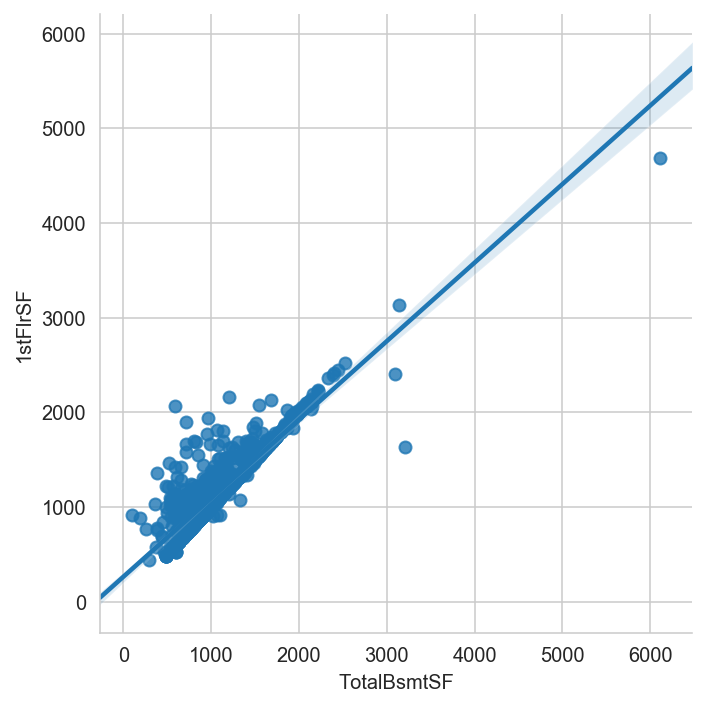

In [333]:
# Exploring correlation among Total basement SF and 1st floor SF
sns.lmplot(x='TotalBsmtSF',y='1stFlrSF',data=house_res_clean)

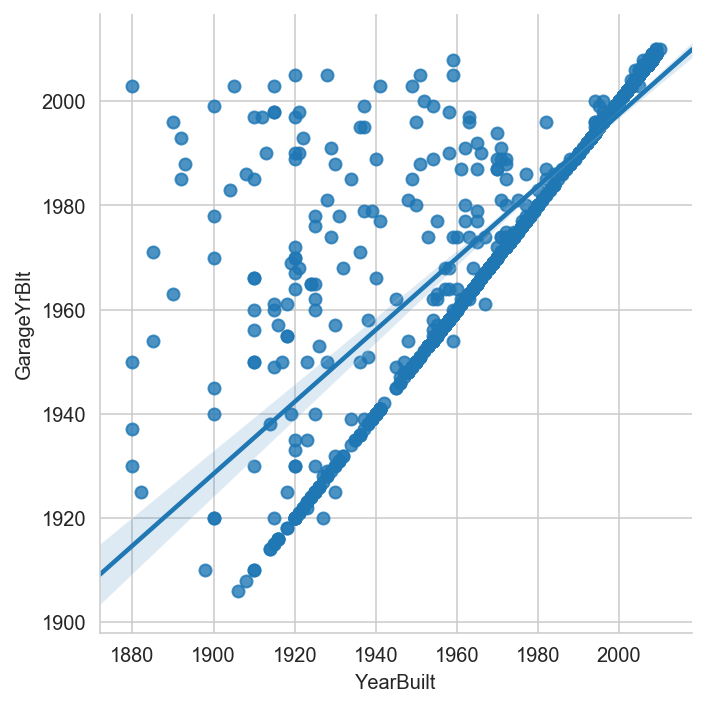

In [334]:
# Exploring correlation among Garage year built and Year built
sns.lmplot(x='YearBuilt',y='GarageYrBlt',data=house_res_clean)

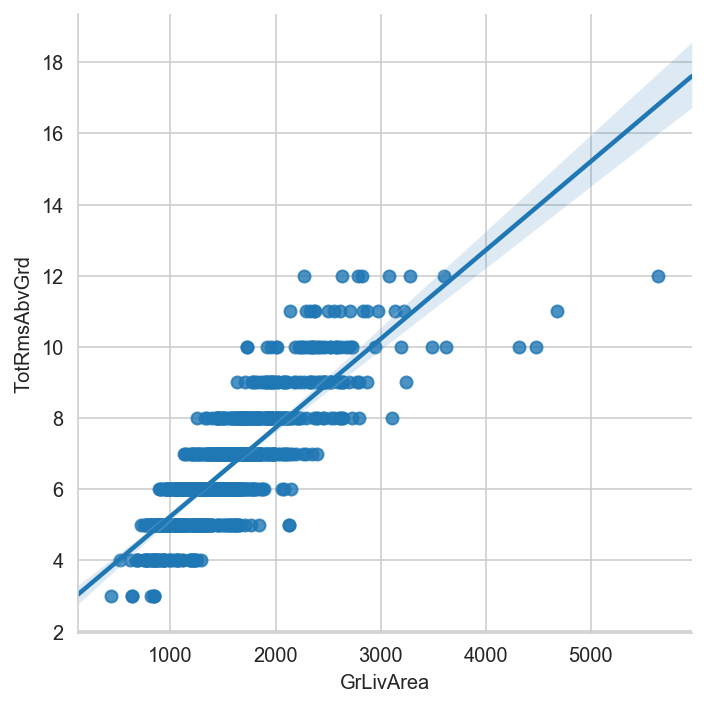

In [335]:
# Exploring correlation among Gr Living Area and Total Rooms above grade
sns.lmplot(x='GrLivArea',y='TotRmsAbvGrd',data=house_res_clean)

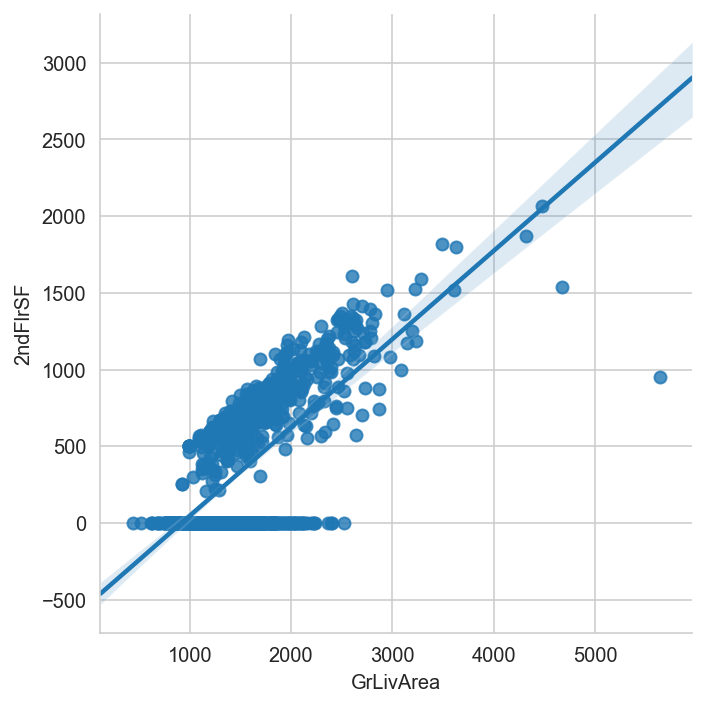

In [336]:
# Exploring correlation among Greater Living Area and 2nd floor SF
sns.lmplot(x='GrLivArea',y='2ndFlrSF',data=house_res_clean)

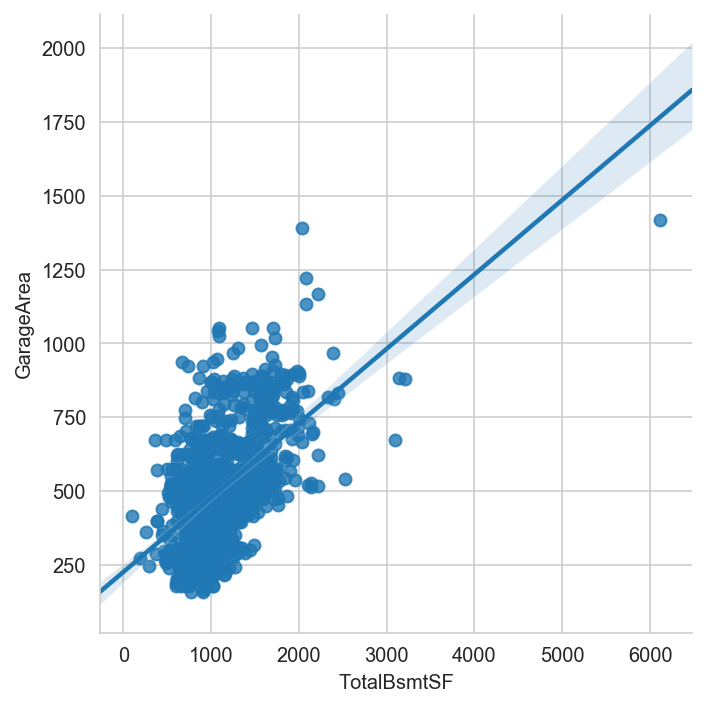

In [337]:
# Exploring correlation among Total basement SF and Garage Area
sns.lmplot(x='TotalBsmtSF',y='GarageArea',data=house_res_clean)

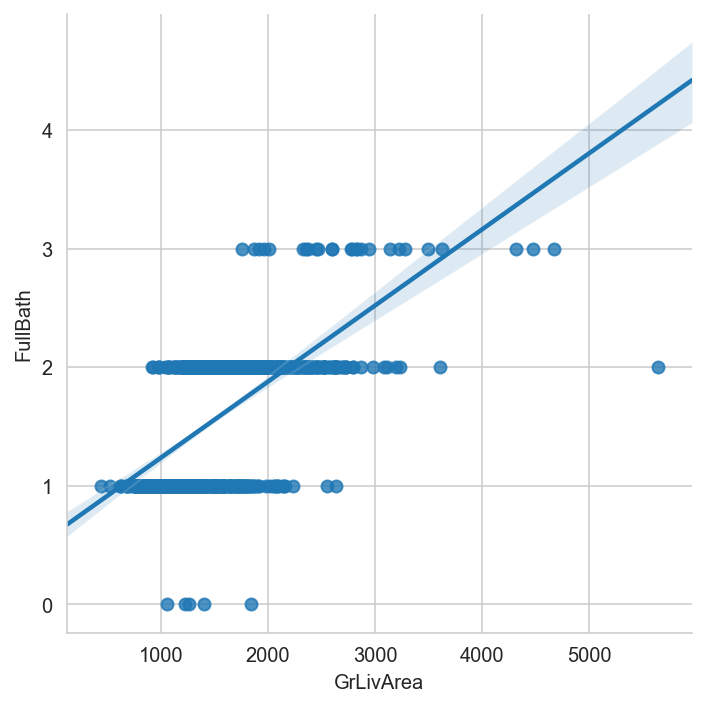

In [338]:
# Exploring correlation among Gr Living Area and Full bath
sns.lmplot(x='GrLivArea',y='FullBath',data=house_res_clean)

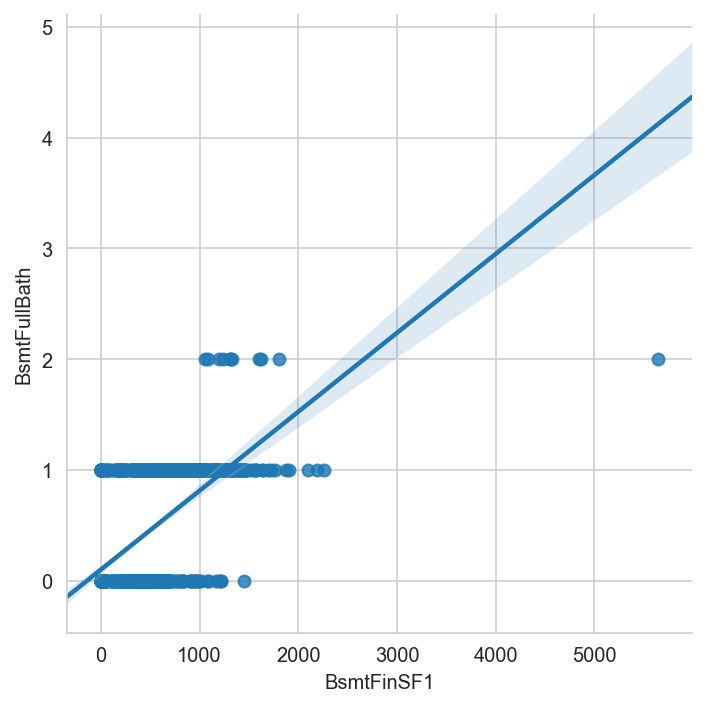

In [339]:
# Exploring correlation among Bsmt Fin SF1 and Bsmt Full bath
sns.lmplot(x='BsmtFinSF1',y='BsmtFullBath',data=house_res_clean)

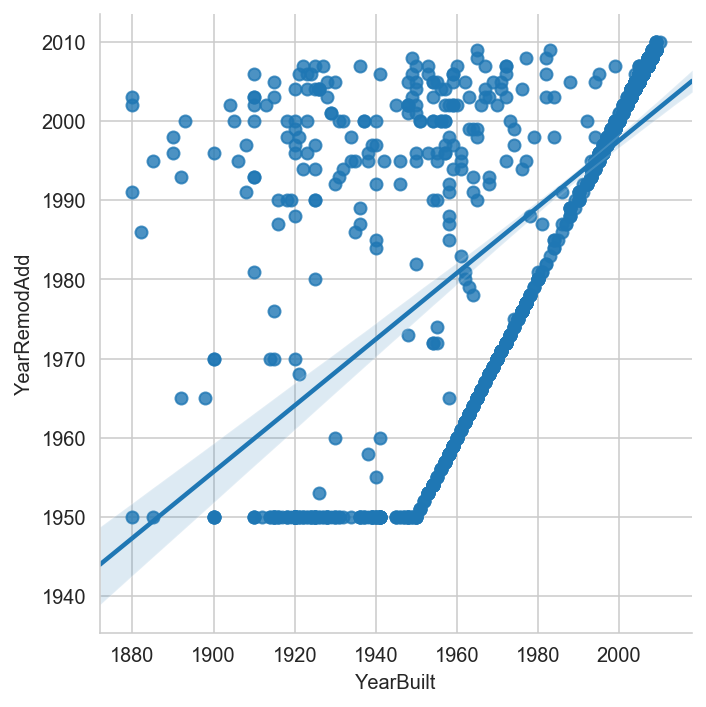

In [340]:
# Exploring correlation among Yr built and Yr Remod Add
sns.lmplot(x='YearBuilt',y='YearRemodAdd',data=house_res_clean)

In [341]:
# As can be seen from the lm plots above, there is a strong correlation among the variables and one of each pair of correlated
# variables can be eliminated to maintain independence of features among each other
# Removing 'GarageCars', '1stFlrSF', 'GarageYrBlt', 'TotRmsAbvGrd'
house_res_clean_0 = house_res_clean_0.drop(['GarageCars','1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'TotRmsAbvGrd'], axis=1)

In [342]:
# Removing Garage column
house_res_clean_0 = house_res_clean_0.drop(['GarageArea'], axis=1)

In [343]:
# Removing Full Bath column
house_res_clean_0 = house_res_clean_0.drop(['FullBath'], axis=1)
house_res_clean_0.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,NaN,NaN,0,12,2008,WD,Normal,250000


In [344]:
# Checking if the house_res_clean has any empty values for the target variable
house_res_clean_0['SalePrice'].isna().sum()

0

In [345]:
# Features to avoid rescaling such as Year sold etc.
time_cols = house_res_clean_0.filter(regex='Yr|Year|Sold').columns
time_cols

Index(['YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold'], dtype='object')

In [346]:
# Numerical features to rescale
house_res_clean_1 = house_res_clean_0.drop(reno, axis=1)
rescale_cols=house_res_clean_1.select_dtypes(exclude='object').drop(time_cols,axis='columns').columns
# Avoid rescaling 'SalePrice' column
rescale_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [347]:
# Applying standard scaler to the numerical features which require scaling
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()

X_rescale_cols=pd.DataFrame(ss.fit_transform(house_res_clean_0[rescale_cols]))
X_rescale_cols.index=house_res_clean_0.index
house_res_clean_0[rescale_cols]=X_rescale_cols

In [348]:
# Printing house_res_clean dataframe
house_res_clean_0.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.093432,RL,-0.236982,-0.204790,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.281898,-0.074104,NaN,NaN,-0.138652,2,2008,WD,Normal,208500
1,-0.862190,RL,0.375262,-0.064994,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,-0.281898,-0.074104,NaN,NaN,-0.138652,5,2007,WD,Normal,181500
2,0.093432,RL,-0.114533,0.135582,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,-0.281898,-0.074104,NaN,NaN,-0.138652,9,2008,WD,Normal,223500
3,0.332338,RL,-0.441063,-0.071072,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,-0.281898,-0.074104,NaN,NaN,-0.138652,2,2006,WD,Abnorml,140000
4,0.093432,RL,0.538527,0.501481,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,-0.281898,-0.074104,NaN,NaN,-0.138652,12,2008,WD,Normal,250000


In [349]:
# Creating another list of renovatable features without SalePrice
reno_1 = reno[0:24]

In [350]:
# Creating a dataframe to get the numerical features from
house_res_clean_2 = house_res_clean_0.drop(reno_1, axis=1)

In [351]:
# Testing the model with all the numerical features in the dataframe
house_res_clean_num = house_res_clean_2.select_dtypes(exclude=['object'])
house_res_clean_num.head()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.093432,-0.236982,-0.204790,2003,2003,0.446461,0.545713,-0.287248,-1.022889,-0.588161,...,-0.773009,0.214204,-0.353607,-0.110518,-0.281898,-0.074104,-0.138652,2,2008,208500
1,-0.862190,0.375262,-0.064994,1976,1976,-0.579807,1.125769,-0.287248,-0.723217,0.376908,...,1.655274,-0.725467,-0.353607,-0.110518,-0.281898,-0.074104,-0.138652,5,2007,181500
2,0.093432,-0.114533,0.135582,2001,2002,0.268435,0.076551,-0.287248,-0.387764,-0.436032,...,-0.773009,-0.078481,-0.353607,-0.110518,-0.281898,-0.074104,-0.138652,9,2008,223500
3,0.332338,-0.441063,-0.071072,1915,1970,-0.579807,-0.499240,-0.287248,-0.150710,-0.825862,...,-0.773009,-0.186312,4.085768,-0.110518,-0.281898,-0.074104,-0.138652,2,2006,140000
4,0.093432,0.538527,0.501481,2000,2000,1.252815,0.436953,-0.287248,-0.262527,0.098797,...,0.791523,0.568506,-0.353607,-0.110518,-0.281898,-0.074104,-0.138652,12,2008,250000


In [352]:
# Splitting the dataset into traning and testing datasets
house_res_clean_num_train = house_res_clean_num[house_res_clean_num['YrSold'] != 2010]
X_train = house_res_clean_num_train.drop(['SalePrice'], axis=1) 
y_train = house_res_clean_num_train.SalePrice
house_res_clean_num_test = house_res_clean_num[house_res_clean_num['YrSold'] == 2010]
X_test = house_res_clean_num_test.drop(['SalePrice'], axis=1) 
y_test = house_res_clean_num_test.SalePrice

In [353]:
# Testing a linear regression model on the numerical data
model = sm.OLS(y_train, X_train).fit()
model1 = model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              864.4
Date:                Fri, 25 Oct 2019   Prob (F-statistic):                        0.00
Time:                        19:57:04   Log-Likelihood:                         -11602.
No. Observations:                 962   AIC:                                  2.325e+04
Df Residuals:                     937   BIC:                                  2.337e+04
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass    -8664.8974   1796.047     -4.824      0.000   -1.22e+04   -5140.156
LotFrontage   -2259.4681   1852.029     -1.220      0.223   -5894.073    1375.137
LotArea        3716.5189   1535.684      2.420      0.016     702.741    6730.297
YearBuilt       592.2659     69.747      8.492      0.000     455.388     729.144
YearRemodAdd    567.9790     92.430      6.145      0.000     386.585     749.373
MasVnrArea     8428.5563   1595.131      5.284      0.000    5298.113    1.16e+04
BsmtFinSF1     1797.2986   1396.290      1.287      0.198    -942.918    4537.516
BsmtFinSF2     -588.7714   1424.824     -0.413      0.680   -3384.986    2207.443
BsmtUnfSF      1788.6059   1263.437      1.416      0.157    -690.888    4268.100
TotalBsmtSF    3680.5901   1660.968      2.216      0.027     420.942    6940.238
GrLivArea      4.615e+04   2710.326     17.026      0.000    4.08e+04    5.15e+04
BsmtFullBath   6370.9049   1992.456      3.198      0.001    2460.713    1.03e+04
BsmtHalfBath    887.5031   1399.732      0.634      0.526   -1859.470    3634.476
HalfBath      -3742.5525   1762.363     -2.124      0.034   -7201.189    -283.916
BedroomAbvGr  -6863.7059   1839.978     -3.730      0.000   -1.05e+04   -3252.751
KitchenAbvGr  -4707.6760   1565.071     -3.008      0.003   -7779.126   -1636.226
Fireplaces     7351.3131   1661.297      4.425      0.000    4091.020    1.06e+04
WoodDeckSF     4183.4132   1544.241      2.709      0.007    1152.842    7213.984
OpenPorchSF     428.5039   1514.479      0.283      0.777   -2543.660    3400.668
EnclosedPorch  1583.3190   1537.974      1.029      0.304   -1434.953    4601.591
3SsnPorch      1382.8979   1318.866      1.049      0.295   -1205.375    3971.171
ScreenPorch    4583.5510   1474.875      3.108      0.002    1689.109    7477.993
PoolArea      -4081.3429   1398.782     -2.918      0.004   -6826.451   -1336.235
MiscVal       -2226.6853   1602.750     -1.389      0.165   -5372.080     918.709
MoSold          322.0682    515.286      0.625      0.532    -689.180    1333.317
YrSold        -1051.6163     80.394    -13.081      0.000   -1209.389    -893.843
==============================================================================
Omnibus:                      494.115   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54477.170
Skew:                          -1.363   Prob(JB):                         0.00
Kurtosis:                      39.765   Cond. No.                     1.01e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue i

In [354]:
# RMSE value on the numerical test data
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

38321.786075888616

In [355]:
# Checking RMSE value in comparison to our null prediction (baseline)
meanprice = y_train.mean()

nullprediction = [meanprice for i in range(len(y_test))]
np.sqrt(mean_squared_error(y_test,  nullprediction))

86153.2000190333

### This shows that in comparison to our baseline model, our numerical dataframe performs with a much better RMSE value.

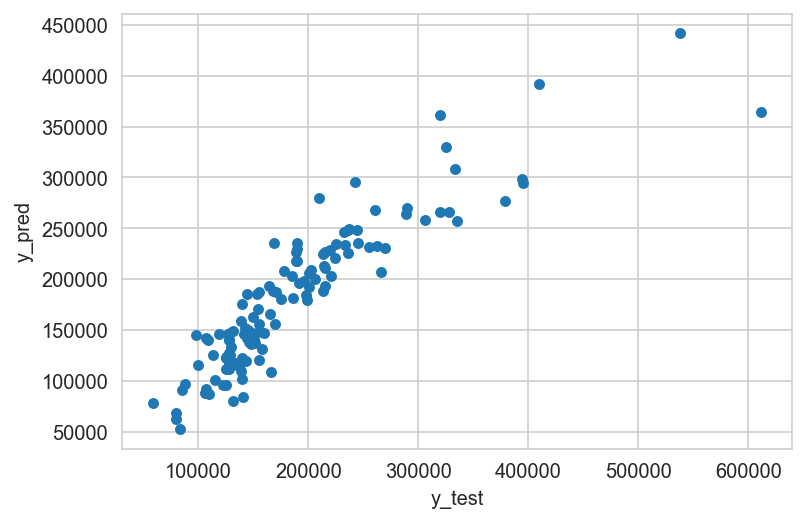

In [356]:
# Scatterplot of how our predicted values fared against the actual y_test values
resultdf = pd.DataFrame(zip(y_test, y_pred), columns = ['y_test', 'y_pred'])
resultdf.plot.scatter('y_test','y_pred')

In [357]:
#Extracting the summary table into a dataframe
results_summary = model.summary()

# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_as_html = results_summary.tables[1].as_html()
summary_df1 = pd.read_html(results_as_html, header=0, index_col=0)[0]
#summary_df1

# Choosing the features from rows with a P-value < 0.05 and putting them into a list
summary_df = summary_df1[summary_df1['P>|t|'] < 0.05]
summary_df = summary_df.sort_values('P>|t|')
print(summary_df)
sig_features = summary_df.index.values
#sig_features

                    coef   std err       t  P>|t|     [0.025     0.975]
MSSubClass    -8664.8974  1796.047  -4.824  0.000 -12200.000  -5140.156
YearBuilt       592.2659    69.747   8.492  0.000    455.388    729.144
YearRemodAdd    567.9790    92.430   6.145  0.000    386.585    749.373
MasVnrArea     8428.5563  1595.131   5.284  0.000   5298.113  11600.000
GrLivArea     46150.0000  2710.326  17.026  0.000  40800.000  51500.000
BedroomAbvGr  -6863.7059  1839.978  -3.730  0.000 -10500.000  -3252.751
Fireplaces     7351.3131  1661.297   4.425  0.000   4091.020  10600.000
YrSold        -1051.6163    80.394 -13.081  0.000  -1209.389   -893.843
BsmtFullBath   6370.9049  1992.456   3.198  0.001   2460.713  10300.000
ScreenPorch    4583.5510  1474.875   3.108  0.002   1689.109   7477.993
KitchenAbvGr  -4707.6760  1565.071  -3.008  0.003  -7779.126  -1636.226
PoolArea      -4081.3429  1398.782  -2.918  0.004  -6826.451  -1336.235
WoodDeckSF     4183.4132  1544.241   2.709  0.007   1152.842   7

In [358]:
# Evaluating the linear regression model on the new X_train dataframe using significant features from above
X_train = X_train[sig_features]
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              1354.
Date:                Fri, 25 Oct 2019   Prob (F-statistic):                        0.00
Time:                        19:57:05   Log-Likelihood:                         -11605.
No. Observations:                 962   AIC:                                  2.324e+04
Df Residuals:                     946   BIC:                                  2.332e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
MSSubClass   -7826.9237   1647.025     -4.752      0.000   -1.11e+04   -4594.678
YearBuilt      572.0373     65.998      8.667      0.000     442.518     701.557
YearRemodAdd   578.2785     90.664      6.378      0.000     400.353     756.204
MasVnrArea    8391.4498   1567.900      5.352      0.000    5314.485    1.15e+04
GrLivArea     4.616e+04   2573.136     17.941      0.000    4.11e+04    5.12e+04
BedroomAbvGr -7395.0078   1788.792     -4.134      0.000   -1.09e+04   -3884.548
Fireplaces    7251.0633   1649.473      4.396      0.000    4014.014    1.05e+04
YrSold       -1040.8233     76.048    -13.686      0.000   -1190.065    -891.582
BsmtFullBath  5846.6126   1480.657      3.949      0.000    2940.861    8752.364
ScreenPorch   3949.6597   1413.796      2.794      0.005    1175.120    6724.200
KitchenAbvGr -4864.1748   1543.820     -3.151      0.002   -7893.883   -1834.467
PoolArea     -4621.6639   1338.953     -3.452      0.001   -7249.326   -1994.002
WoodDeckSF    4165.5279   1511.936      2.755      0.006    1198.392    7132.664
LotArea       3077.2571   1470.296      2.093      0.037     191.837    5962.677
TotalBsmtSF   5260.1413   2270.039      2.317      0.021     805.246    9715.036
HalfBath     -3649.8023   1740.906     -2.096      0.036   -7066.286    -233.318
==============================================================================
Omnibus:                      510.701   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58399.839
Skew:                          -1.437   Prob(JB):                         0.00
Kurtosis:                      41.062   Cond. No.                     8.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [359]:
# RMSE value on the numerical test data
X_test = X_test[sig_features] 
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

37992.39457669934

In [360]:
X_test.columns

Index(['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea',
       'BedroomAbvGr', 'Fireplaces', 'YrSold', 'BsmtFullBath', 'ScreenPorch',
       'KitchenAbvGr', 'PoolArea', 'WoodDeckSF', 'LotArea', 'TotalBsmtSF',
       'HalfBath'],
      dtype='object')

In [361]:
# Now I am choosing which categorical variables can be included to our 
# numerical data features

# All categorical columns
object_cols = [col for col in house_res_clean.columns if house_res_clean[col].dtype == "object"]

In [362]:
# Changing Central Air column values to 1 & 0.
house_res_clean_cat = house_res_clean[['CentralAir']]
house_res_clean_cat['CentralAir'] = house_res_clean_cat['CentralAir'].map({'Y': 1, 'N': 0})
house_res_clean_cat.head()

,CentralAir
0,1
1,1
2,1
3,1
4,1


In [363]:
# Applying Dummy Encoding to LandContour
type_dummy = pd.get_dummies(house_res_clean['LandContour'])
type_dummy.head()

,Bnk,HLS,Low,Lvl
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [364]:
types_dummy = pd.get_dummies(house_res_clean)
types_dummy.shape

(1088, 146)

In [365]:
# Applying Dummy Encoding contd...
type_dummy.drop('Lvl', axis=1, inplace=True)
house_res_clean_cat = pd.concat([house_res_clean_cat, type_dummy], axis=1)
house_res_clean_cat.head(2)

,CentralAir,Bnk,HLS,Low
0,1,0,0,0
1,1,0,0,0


In [366]:
# Applying more encoding on ordinal categorical features
house_res_clean_cat['LotShape'] =  house_res_clean['LotShape'].map({'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3})

In [367]:
house_res_clean_cat['Utilities'] =  house_res_clean['Utilities'].map({'ELO': 0, 'NoSeWa': 1, 'NoSeWr': 2, 'AllPub': 3})

In [368]:
house_res_clean_cat['LandSlope'] =  house_res_clean['LandSlope'].map({'Sev': 0, 'Mod': 1, 'Gtl': 2})

In [369]:
house_res_clean_cat['BsmtExposure'] =  house_res_clean['BsmtExposure'].map({'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd':4})

In [370]:
house_res_clean_cat['Functional'] =  house_res_clean['Functional'].map({'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})

In [371]:
house_res_clean_cat['GarageType'] =  house_res_clean['GarageType'].map({'NA': 0, 'Detchd': 1, 'CarPort': 2, 'BuiltIn': 3, 'Basment': 4, 'Attchd': 5, '2Types': 6})

In [372]:
house_res_clean_cat['LotConfig'] =  house_res_clean['LotConfig'].map({'FR3': 0, 'FR2': 1, 'CulDSac': 2, 'Corner': 3, 'Inside': 4})

In [373]:
house_res_clean_cat['Street'] =  house_res_clean['Street'].map({'Grvl': 0, 'Pave': 1})

In [374]:
# Standard scaling the house_res_clean_cat dataframe
X_rescale_cols=pd.DataFrame(ss.fit_transform(house_res_clean_cat))
X_rescale_cols.index=house_res_clean_cat.index
rescale_cols = house_res_clean_cat.columns
house_res_clean_cat[rescale_cols]=X_rescale_cols

# Joining the categorical dataframe to the numerical dataframe
house_res_clean_final = pd.concat([house_res_clean_num, house_res_clean_cat], axis=1)
house_res_clean_final.head()

,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,HLS,Low,LotShape,Utilities,LandSlope,BsmtExposure,Functional,GarageType,LotConfig,Street
0,0.093432,-0.236982,-0.204790,2003,2003,0.446461,0.545713,-0.287248,-1.022889,-0.588161,...,-0.202851,-0.105605,0.616790,0.0,0.201963,-0.640233,0.230819,0.726633,0.484559,0.042914
1,-0.862190,0.375262,-0.064994,1976,1976,-0.579807,1.125769,-0.287248,-0.723217,0.376908,...,-0.202851,-0.105605,0.616790,0.0,0.201963,2.254117,0.230819,0.726633,-3.710665,0.042914
2,0.093432,-0.114533,0.135582,2001,2002,0.268435,0.076551,-0.287248,-0.387764,-0.436032,...,-0.202851,-0.105605,-1.172724,0.0,0.201963,0.324550,0.230819,0.726633,0.484559,0.042914
3,0.332338,-0.441063,-0.071072,1915,1970,-0.579807,-0.499240,-0.287248,-0.150710,-0.825862,...,-0.202851,-0.105605,-1.172724,0.0,0.201963,-0.640233,0.230819,-1.487867,-0.913849,0.042914
4,0.093432,0.538527,0.501481,2000,2000,1.252815,0.436953,-0.287248,-0.262527,0.098797,...,-0.202851,-0.105605,-1.172724,0.0,0.201963,1.289333,0.230819,0.726633,-3.710665,0.042914


In [375]:
# Splitting the dataset into traning and testing datasets
house_res_clean_final_train = house_res_clean_final[house_res_clean_final['YrSold'] != 2010]
X_train = house_res_clean_final_train.drop(['SalePrice'], axis=1) 
y_train = house_res_clean_final_train.SalePrice
house_res_clean_final_test = house_res_clean_final[house_res_clean_final['YrSold'] == 2010]
X_test = house_res_clean_final_test.drop(['SalePrice'], axis=1) 
y_test = house_res_clean_final_test.SalePrice

In [376]:
# Testing a linear regression model on the numerical + few categorical features
model = sm.OLS(y_train, X_train).fit()
model2 = model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                              644.6
Date:                Fri, 25 Oct 2019   Prob (F-statistic):                        0.00
Time:                        19:57:05   Log-Likelihood:                         -11563.
No. Observations:                 962   AIC:                                  2.320e+04
Df Residuals:                     926   BIC:                                  2.337e+04
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass    -9726.0562   1760.827     -5.524      0.000   -1.32e+04   -6270.383
LotFrontage   -3474.6045   1839.603     -1.889      0.059   -7084.879     135.671
LotArea        3570.0975   1709.366      2.089      0.037     215.418    6924.777
YearBuilt       549.5670     76.372      7.196      0.000     399.684     699.450
YearRemodAdd    515.7297     90.185      5.719      0.000     338.740     692.720
MasVnrArea     7340.8744   1563.446      4.695      0.000    4272.566    1.04e+04
BsmtFinSF1     1452.9866   1365.879      1.064      0.288   -1227.592    4133.565
BsmtFinSF2       50.4833   1397.410      0.036      0.971   -2691.974    2792.940
BsmtUnfSF      1729.7618   1226.334      1.411      0.159    -676.954    4136.477
TotalBsmtSF    3477.2941   1620.664      2.146      0.032     296.695    6657.893
GrLivArea      4.803e+04   2667.552     18.004      0.000    4.28e+04    5.33e+04
BsmtFullBath   5010.5113   1949.124      2.571      0.010    1185.298    8835.725
BsmtHalfBath      3.4167   1366.852      0.002      0.998   -2679.071    2685.904
HalfBath      -3000.4284   1728.982     -1.735      0.083   -6393.606     392.749
BedroomAbvGr  -6651.8453   1793.816     -3.708      0.000   -1.02e+04   -3131.430
KitchenAbvGr  -4702.1427   1539.459     -3.054      0.002   -7723.376   -1680.909
Fireplaces     7487.3437   1645.406      4.550      0.000    4258.187    1.07e+04
WoodDeckSF     3429.3751   1523.549      2.251      0.025     439.365    6419.385
OpenPorchSF     303.3696   1498.153      0.202      0.840   -2636.800    3243.539
EnclosedPorch  1107.5185   1492.912      0.742      0.458   -1822.364    4037.401
3SsnPorch      1598.9617   1279.547      1.250      0.212    -912.187    4110.111
ScreenPorch    4654.0645   1444.625      3.222      0.001    1818.947    7489.182
PoolArea      -4007.4279   1360.691     -2.945      0.003   -6677.823   -1337.032
MiscVal       -1725.1130   1558.506     -1.107      0.269   -4783.725    1333.499
MoSold          112.8021    502.895      0.224      0.823    -874.144    1099.748
YrSold         -957.3549     88.961    -10.762      0.000   -1131.943    -782.767
CentralAir    -1036.2981   1484.670     -0.698      0.485   -3950.006    1877.410
Bnk           -4171.6872   1403.452     -2.972      0.003   -6926.002   -1417.372
HLS            2942.7483   1399.205      2.103      0.036     196.769    5688.728
Low             171.5035   1557.589      0.110      0.912   -2885.310    3228.317
LotShape       1295.6345   1542.088      0.840      0.401   -1730.758    4322.027
Utilities      1.173e-12      3e-13      3.905      0.000    5.83e-13    1.76e-12
LandSlope      1365.7608   1621.038      0.843      0.400   -1815.573    4547.094
BsmtExposure   8083.5123   1580.

In [377]:
# RMSE value on the test data
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

37328.807504244396

In [378]:
# Testing the performance of the linear model using cross validated R-square value
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, X_train, y_train, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[0.84310202 0.77862187 0.76192143 0.53869256 0.78492841 0.79141483
 0.81950231 0.7424856  0.19967261 0.76157125]
0.7021912878510914


In [379]:
# Trying a LassoCV on the above dataframe to check performance of the 
# cross-validated R-square value
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1, n_jobs=8)
optimal_lasso.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=500, n_jobs=8, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=1)

In [380]:
# Finding the R-squared from the Lasso Model
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.84502102 0.77251879 0.8218741  0.58023529 0.77725142 0.79763104
 0.83994106 0.75670627 0.23261351 0.76376867]
0.7187561159758197


In [381]:
# Fitting the lasso model on the training data and obtaining the coefficients of the features
lasso.fit(X_train, y_train)

lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs

,variable,coef,abs_coef
10,GrLivArea,42355.961057,42355.961057
33,BsmtExposure,7600.578792,7600.578792
9,TotalBsmtSF,6870.241466,6870.241466
5,MasVnrArea,6796.388788,6796.388788
16,Fireplaces,6636.593196,6636.593196
0,MSSubClass,-6555.797228,6555.797228
34,Functional,4849.901447,4849.901447
14,BedroomAbvGr,-4020.499724,4020.499724
15,KitchenAbvGr,-3865.421712,3865.421712
11,BsmtFullBath,3376.729494,3376.729494


In [382]:
# Taking significant features out and making a linear model again
lasso_coefs1 = lasso_coefs[lasso_coefs['coef'] > 0]
sig = lasso_coefs1.variable.values

In [383]:
# Testing a linear regression model on the significant features
model = sm.OLS(y_train, X_train[sig]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              1248.
Date:                Fri, 25 Oct 2019   Prob (F-statistic):                        0.00
Time:                        19:57:08   Log-Likelihood:                         -11704.
No. Observations:                 962   AIC:                                  2.344e+04
Df Residuals:                     948   BIC:                                  2.350e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
GrLivArea     3.978e+04   2032.349     19.574      0.000    3.58e+04    4.38e+04
BsmtExposure  1.095e+04   1715.091      6.387      0.000    7587.907    1.43e+04
TotalBsmtSF   1.473e+04   1967.755      7.487      0.000    1.09e+04    1.86e+04
MasVnrArea    8576.7437   1729.542      4.959      0.000    5182.571     1.2e+04
Fireplaces    6441.7066   1799.083      3.581      0.000    2911.060    9972.353
Functional    8313.2251   1505.866      5.521      0.000    5358.010    1.13e+04
BsmtFullBath  3982.5260   1644.982      2.421      0.016     754.298    7210.754
ScreenPorch   2664.9211   1556.140      1.713      0.087    -388.955    5718.798
WoodDeckSF    6724.9549   1671.240      4.024      0.000    3445.198       1e+04
LotArea         52.8835   1604.913      0.033      0.974   -3096.709    3202.477
HLS           3459.3778   1491.279      2.320      0.021     532.787    6385.968
YearRemodAdd  -176.3730     67.340     -2.619      0.009    -308.526     -44.220
YearBuilt      271.3618     67.772      4.004      0.000     138.362     404.362
MoSold         420.4772    563.968      0.746      0.456    -686.293    1527.247
==============================================================================
Omnibus:                      651.002   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61319.735
Skew:                          -2.254   Prob(JB):                         0.00
Kurtosis:                      41.852   Cond. No.                     4.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [384]:
# RMSE value on the test data
y_pred = model.predict(X_test[sig])
np.sqrt(mean_squared_error(y_test, y_pred))

42567.08522919717

### Adding the 'CentralAir' feature by label encoding it and also adding the 'LandContour' feature by one-hot encoding it, has dropped the RMSE value by 1000 in comparison to the RMSE generated by using the numerical features alone. This has been clearly a better model than the previous one even in terms of the R-squared value as can be seen from the OLS model summary.

### Comparing the cross validation on the linear regression model and the Lasso model shows that the Lasso model performs better.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [385]:
# Checking the shape of two dataframes, one which has both fixed and 
# renovatable features and one which has only the fixed features

print(house_res_clean_0.shape)
print(house_res_clean_final.shape)

# They both have the same number of rows so this makes adding the predicted 
# values as a new column easy

(1088, 71)
(1088, 39)


In [386]:
# Using the whole dataset from all years including 2010 as our test set
# to get the complete list of predicted house prices to use in Question 2
complete_test = house_res_clean_final.drop(['SalePrice'], axis=1) 
complete_y_pred = model2.predict(complete_test)
len(complete_y_pred)

1088

In [387]:
# Appending this predicted list as a column to house_res_clean_0
house_res_clean_0['PredictedSalePrice'] = complete_y_pred
house_res_clean_0.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PredictedSalePrice
0,0.093432,RL,-0.236982,-0.204790,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.074104,NaN,NaN,-0.138652,2,2008,WD,Normal,208500,212140.249851
1,-0.862190,RL,0.375262,-0.064994,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,-0.074104,NaN,NaN,-0.138652,5,2007,WD,Normal,181500,191101.052183
2,0.093432,RL,-0.114533,0.135582,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,-0.074104,NaN,NaN,-0.138652,9,2008,WD,Normal,223500,235917.251701
3,0.332338,RL,-0.441063,-0.071072,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,-0.074104,NaN,NaN,-0.138652,2,2006,WD,Abnorml,140000,168095.237589
4,0.093432,RL,0.538527,0.501481,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,-0.074104,NaN,NaN,-0.138652,12,2008,WD,Normal,250000,288880.503200


In [388]:
# Choosing only the renovated features for Question 2
reno_new = reno.copy()
reno_new.append('PredictedSalePrice')
house_r = pd.DataFrame(data=house_res_clean_0, columns=reno_new)
# Adding the YrSold column to identify each house by year
house_r['YrSold'] = house_res_clean_0['YrSold']
house_r.head()

,OverallQual,ExterQual,BsmtQual,LowQualFinSF,KitchenQual,GarageQual,OverallCond,ExterCond,GarageCond,BsmtCond,...,PoolQC,BsmtFinType2,BsmtFinType1,FireplaceQu,GarageFinish,PavedDrive,Fence,SalePrice,PredictedSalePrice,YrSold
0,7,Gd,Gd,0,Gd,TA,5,TA,TA,TA,...,NaN,Unf,GLQ,NaN,RFn,Y,NaN,208500,212140.249851,2008
1,6,TA,Gd,0,TA,TA,8,TA,TA,TA,...,NaN,Unf,ALQ,TA,RFn,Y,NaN,181500,191101.052183,2007
2,7,Gd,Gd,0,Gd,TA,5,TA,TA,TA,...,NaN,Unf,GLQ,TA,RFn,Y,NaN,223500,235917.251701,2008
3,7,TA,TA,0,Gd,TA,5,TA,TA,Gd,...,NaN,Unf,ALQ,Gd,Unf,Y,NaN,140000,168095.237589,2006
4,8,Gd,Gd,0,Gd,TA,5,TA,TA,TA,...,NaN,Unf,GLQ,TA,RFn,Y,NaN,250000,288880.503200,2008


In [389]:
# Engineering a new column for the residuals - Predicted - Actual
house_r['Residuals'] = house_r['SalePrice'] - house_r['PredictedSalePrice']

In [390]:
# Rounding off values to two decimal places in PredictedSalePrice and Residuals
house_r['PredictedSalePrice'] = house_r['PredictedSalePrice'].round(2)
house_r['Residuals'] = house_r['Residuals'].round(2)
house_r.head()

,OverallQual,ExterQual,BsmtQual,LowQualFinSF,KitchenQual,GarageQual,OverallCond,ExterCond,GarageCond,BsmtCond,...,BsmtFinType2,BsmtFinType1,FireplaceQu,GarageFinish,PavedDrive,Fence,SalePrice,PredictedSalePrice,YrSold,Residuals
0,7,Gd,Gd,0,Gd,TA,5,TA,TA,TA,...,Unf,GLQ,NaN,RFn,Y,NaN,208500,212140.25,2008,-3640.25
1,6,TA,Gd,0,TA,TA,8,TA,TA,TA,...,Unf,ALQ,TA,RFn,Y,NaN,181500,191101.05,2007,-9601.05
2,7,Gd,Gd,0,Gd,TA,5,TA,TA,TA,...,Unf,GLQ,TA,RFn,Y,NaN,223500,235917.25,2008,-12417.25
3,7,TA,TA,0,Gd,TA,5,TA,TA,Gd,...,Unf,ALQ,Gd,Unf,Y,NaN,140000,168095.24,2006,-28095.24
4,8,Gd,Gd,0,Gd,TA,5,TA,TA,TA,...,Unf,GLQ,TA,RFn,Y,NaN,250000,288880.50,2008,-38880.50


In [391]:
# Checking for null values in the dataframe
house_r.isna().sum()

OverallQual              0
ExterQual                0
BsmtQual                 0
LowQualFinSF             0
KitchenQual              0
GarageQual               0
OverallCond              0
ExterCond                0
GarageCond               0
BsmtCond                 0
SaleCondition            0
RoofStyle                0
RoofMatl                 0
Exterior1st              0
Exterior2nd              0
Heating                  0
HeatingQC                0
Electrical               1
PoolQC                1082
BsmtFinType2             1
BsmtFinType1             0
FireplaceQu            505
GarageFinish             0
PavedDrive               0
Fence                  877
SalePrice                0
PredictedSalePrice       0
YrSold                   0
Residuals                0
dtype: int64

In [392]:
# Checking the data types of all variables
house_r.dtypes

OverallQual             int64
ExterQual              object
BsmtQual               object
LowQualFinSF            int64
KitchenQual            object
GarageQual             object
OverallCond             int64
ExterCond              object
GarageCond             object
BsmtCond               object
SaleCondition          object
RoofStyle              object
RoofMatl               object
Exterior1st            object
Exterior2nd            object
Heating                object
HeatingQC              object
Electrical             object
PoolQC                 object
BsmtFinType2           object
BsmtFinType1           object
FireplaceQu            object
GarageFinish           object
PavedDrive             object
Fence                  object
SalePrice               int64
PredictedSalePrice    float64
YrSold                  int64
Residuals             float64
dtype: object

In [393]:
# Exploring the one row which has the Electrical column value as NA which is 
# not present in the data dictionary
house_r.loc[house_r['Electrical'].isna() == True]

,OverallQual,ExterQual,BsmtQual,LowQualFinSF,KitchenQual,GarageQual,OverallCond,ExterCond,GarageCond,BsmtCond,...,BsmtFinType2,BsmtFinType1,FireplaceQu,GarageFinish,PavedDrive,Fence,SalePrice,PredictedSalePrice,YrSold,Residuals
1379,5,TA,Gd,0,Gd,TA,5,TA,TA,TA,...,Unf,Unf,NaN,Fin,Y,NaN,167500,165602.95,2008,1897.05


In [394]:
# Removing the row with Electrical value as NaN as it is not specified in the
# data dictionary
house_r = house_r.dropna(subset=['Electrical'])
house_r.isna().sum()

OverallQual              0
ExterQual                0
BsmtQual                 0
LowQualFinSF             0
KitchenQual              0
GarageQual               0
OverallCond              0
ExterCond                0
GarageCond               0
BsmtCond                 0
SaleCondition            0
RoofStyle                0
RoofMatl                 0
Exterior1st              0
Exterior2nd              0
Heating                  0
HeatingQC                0
Electrical               0
PoolQC                1081
BsmtFinType2             1
BsmtFinType1             0
FireplaceQu            504
GarageFinish             0
PavedDrive               0
Fence                  876
SalePrice                0
PredictedSalePrice       0
YrSold                   0
Residuals                0
dtype: int64

In [395]:
# Replacing all NaN values to zero 
house_r = house_r.fillna('NA')
house_r.isna().sum()

OverallQual           0
ExterQual             0
BsmtQual              0
LowQualFinSF          0
KitchenQual           0
GarageQual            0
OverallCond           0
ExterCond             0
GarageCond            0
BsmtCond              0
SaleCondition         0
RoofStyle             0
RoofMatl              0
Exterior1st           0
Exterior2nd           0
Heating               0
HeatingQC             0
Electrical            0
PoolQC                0
BsmtFinType2          0
BsmtFinType1          0
FireplaceQu           0
GarageFinish          0
PavedDrive            0
Fence                 0
SalePrice             0
PredictedSalePrice    0
YrSold                0
Residuals             0
dtype: int64

In [396]:
# Checking if there are any null values in the Fireplace Quality column
house_r['FireplaceQu'].isna().sum()

0

In [397]:
# Checking the value counts of values from the Fireplace Quality column
house_r['FireplaceQu'].value_counts()

NA    504
Gd    315
TA    212
Fa     24
Ex     20
Po     12
Name: FireplaceQu, dtype: int64

In [398]:
# Applying map function on each column to convert text to numericals
house_r['ExterQual'] = house_r['ExterQual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 })

In [399]:
house_r['BsmtQual'] = house_r['BsmtQual'].map({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 })

In [400]:
house_r['KitchenQual'] = house_r['KitchenQual'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 })

In [401]:
house_r['GarageQual'] = house_r['GarageQual'].map({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 })

In [402]:
house_r['ExterCond'] = house_r['ExterCond'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 })

In [403]:
house_r['GarageCond'] = house_r['GarageCond'].map({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 })

In [404]:
house_r['BsmtCond'] = house_r['BsmtCond'].map({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 })

In [405]:
house_r['HeatingQC'] = house_r['HeatingQC'].map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 })

In [406]:
house_r['PoolQC'] = house_r['PoolQC'].map({'NA': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4 })

In [407]:
house_r['BsmtFinType1'] = house_r['BsmtFinType1'].map({'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6 })

In [408]:
house_r['BsmtFinType2'] = house_r['BsmtFinType2'].map({'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6 })

In [409]:
house_r['FireplaceQu'] = house_r['FireplaceQu'].map({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 })

In [410]:
house_r['GarageFinish'] = house_r['GarageFinish'].map({'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3 })

In [411]:
house_r['PavedDrive'] = house_r['PavedDrive'].map({'N': 0, 'P': 1, 'Y': 2 })

In [412]:
house_r['Fence'] = house_r['Fence'].map({'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4 })

In [413]:
# Checking how our dataframe with renovatable features looks like now
house_r.head()

,OverallQual,ExterQual,BsmtQual,LowQualFinSF,KitchenQual,GarageQual,OverallCond,ExterCond,GarageCond,BsmtCond,...,BsmtFinType2,BsmtFinType1,FireplaceQu,GarageFinish,PavedDrive,Fence,SalePrice,PredictedSalePrice,YrSold,Residuals
0,7,4,4,0,4,3,5,3,3,3,...,1,6,0,2,2,0,208500,212140.25,2008,-3640.25
1,6,3,4,0,3,3,8,3,3,3,...,1,5,3,2,2,0,181500,191101.05,2007,-9601.05
2,7,4,4,0,4,3,5,3,3,3,...,1,6,3,2,2,0,223500,235917.25,2008,-12417.25
3,7,3,3,0,4,3,5,3,3,4,...,1,5,4,1,2,0,140000,168095.24,2006,-28095.24
4,8,4,4,0,4,3,5,3,3,3,...,1,6,3,2,2,0,250000,288880.50,2008,-38880.50


In [414]:
# Removing all object type variables from our dataset to make a linear
# regression model on the numerical renovatable features
house_r_n = house_r.select_dtypes(exclude=['object'])
house_r_n.dtypes

OverallQual             int64
ExterQual               int64
BsmtQual                int64
LowQualFinSF            int64
KitchenQual             int64
GarageQual              int64
OverallCond             int64
ExterCond               int64
GarageCond              int64
BsmtCond                int64
HeatingQC               int64
PoolQC                  int64
BsmtFinType2            int64
BsmtFinType1            int64
FireplaceQu             int64
GarageFinish            int64
PavedDrive              int64
Fence                   int64
SalePrice               int64
PredictedSalePrice    float64
YrSold                  int64
Residuals             float64
dtype: object

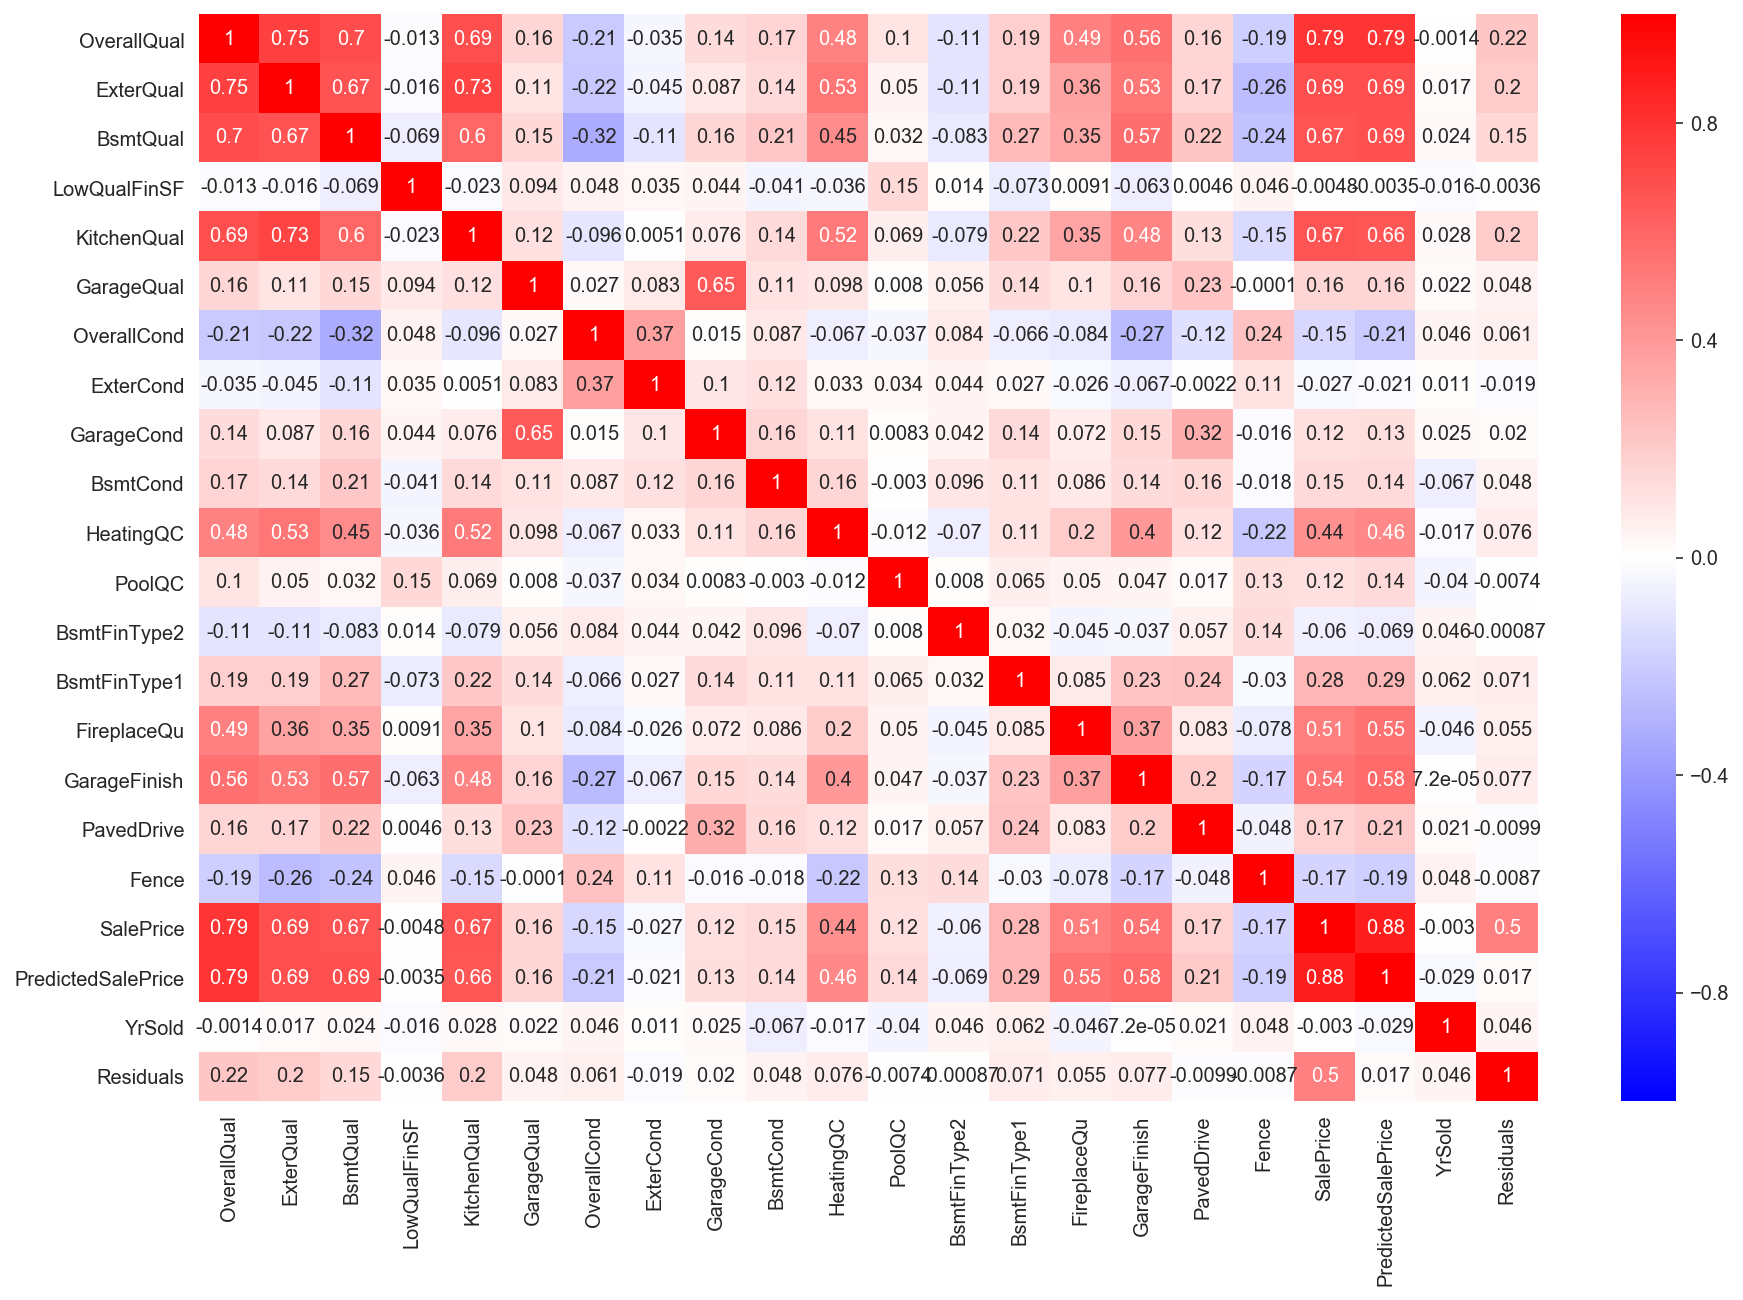

In [415]:
# Plotting correlation matrix for this dataframe to check multi-collinearity
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(house_r_n.corr(), vmin = -1, vmax = 1, cmap= 'bwr',annot= True, ax=ax )

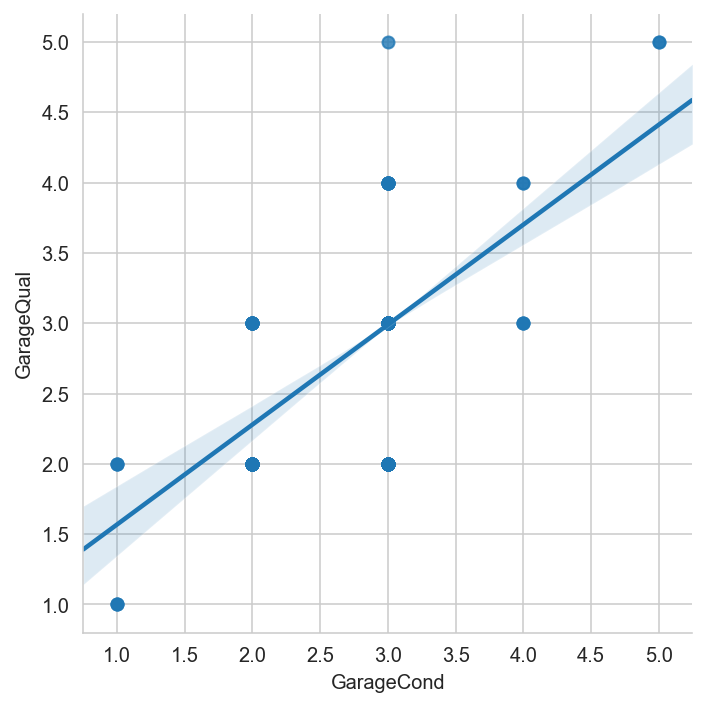

In [416]:
#  Exploring correlation among Garage Condition and Garage Quality
sns.lmplot(x='GarageCond',y='GarageQual',data=house_r_n)

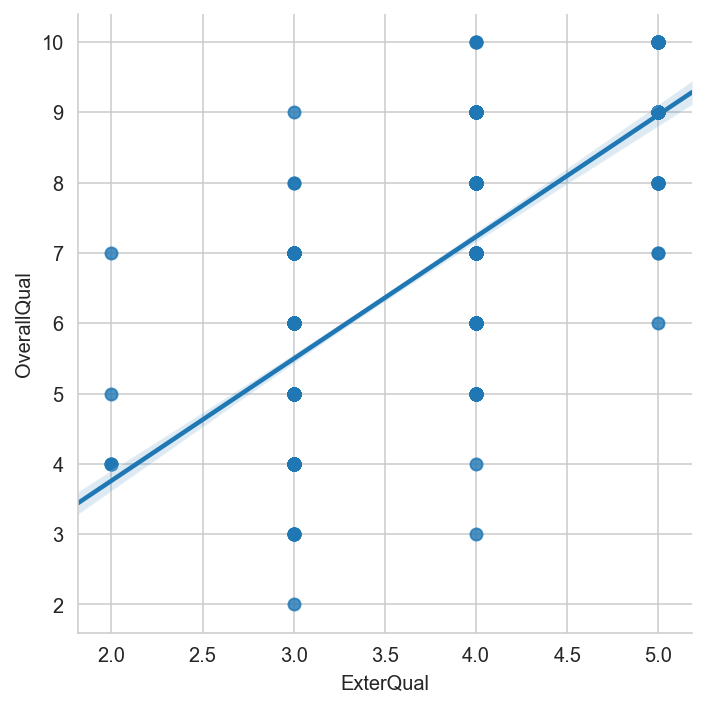

In [417]:
#  Exploring correlation among Kitchen Qual and Exter Qual
sns.lmplot(x='ExterQual',y='OverallQual',data=house_r_n)

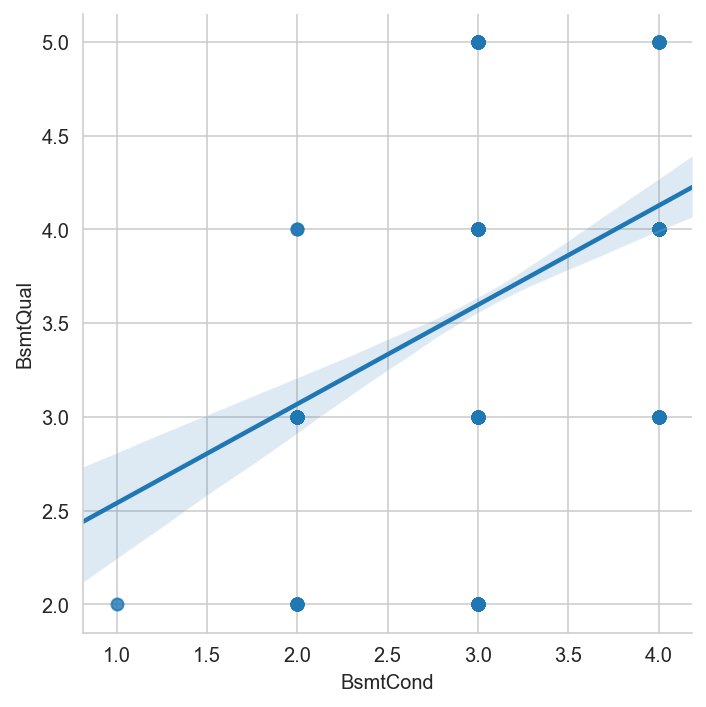

In [418]:
#  Exploring correlation among Bsmt Cond and Bsmt Qual
sns.lmplot(x='BsmtCond',y='BsmtQual',data=house_r_n)

In [419]:
# Dropping three columns from the dataframe which have multi-collinearity issues
house_rni = house_r_n.drop(['ExterQual', 'GarageCond', 'BsmtCond'], axis=1)

In [420]:
# Splitting the dataset into traning and testing datasets
house_rni_train = house_rni[house_rni['YrSold'] != 2010]
X_train = house_rni_train.drop(['SalePrice', 'PredictedSalePrice', 'Residuals', 'YrSold'], axis=1) 
y_train = house_rni_train.Residuals
house_rni_test = house_rni[house_rni['YrSold'] == 2010]
X_test = house_rni_test.drop(['SalePrice', 'PredictedSalePrice', 'Residuals', 'YrSold'], axis=1) 
y_test = house_rni_test.Residuals

In [421]:
# Testing a linear regression model on the training data to identify the contribution to house price from the 
# coefficients of the renovatable features
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Residuals   R-squared (uncentered):                   0.068
Model:                            OLS   Adj. R-squared (uncentered):              0.053
Method:                 Least Squares   F-statistic:                              4.600
Date:                Fri, 25 Oct 2019   Prob (F-statistic):                    1.49e-08
Time:                        19:57:20   Log-Likelihood:                         -11518.
No. Observations:                 961   AIC:                                  2.307e+04
Df Residuals:                     946   BIC:                                  2.314e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
OverallQual   7787.0577   1609.221      4.839      0.000    4629.002    1.09e+04
BsmtQual      -587.6944   2725.248     -0.216      0.829   -5935.925    4760.536
LowQualFinSF    10.2725     30.022      0.342      0.732     -48.645      69.190
KitchenQual   3481.7587   2791.754      1.247      0.213   -1996.989    8960.506
GarageQual   -5508.3278   3932.597     -1.401      0.162   -1.32e+04    2209.295
OverallCond   4222.0583   1354.757      3.116      0.002    1563.382    6880.734
ExterCond    -1.433e+04   3680.282     -3.895      0.000   -2.16e+04   -7110.868
HeatingQC    -2513.7100   1683.645     -1.493      0.136   -5817.822     790.402
PoolQC       -5487.4384   5655.169     -0.970      0.332   -1.66e+04    5610.688
BsmtFinType2   854.6283   1508.138      0.567      0.571   -2105.055    3814.312
BsmtFinType1   888.9507    653.629      1.360      0.174    -393.779    2171.680
FireplaceQu  -1092.3613    803.023     -1.360      0.174   -2668.274     483.551
GarageFinish -2287.7628   2062.961     -1.109      0.268   -6336.272    1760.746
PavedDrive   -4964.5057   3135.285     -1.583      0.114   -1.11e+04    1188.412
Fence          353.4227   1155.399      0.306      0.760   -1914.019    2620.865
==============================================================================
Omnibus:                      678.471   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            84280.326
Skew:                          -2.333   Prob(JB):                         0.00
Kurtosis:                      48.640   Cond. No.                         195.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [422]:
# Fitting a lasso regression on the training data and obtaining the coefficients of the features
lasso_reg = Lasso(normalize=True)
lasso_reg.fit(X_train, y_train)
lasso_coefs = pd.DataFrame({'variable': X_train.columns,'coef': 
                                lasso_reg.coef_, 'abs_coef': np.abs(
                                    lasso_reg.coef_) })
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs

,variable,coef,abs_coef
6,ExterCond,-7784.241207,7784.241207
0,OverallQual,7774.636815,7774.636815
8,PoolQC,-5407.106511,5407.106511
5,OverallCond,5134.457975,5134.457975
3,KitchenQual,4376.834022,4376.834022
13,PavedDrive,-3812.098185,3812.098185
12,GarageFinish,-2764.966265,2764.966265
4,GarageQual,2465.291745,2465.291745
7,HeatingQC,-2130.918468,2130.918468
11,FireplaceQu,-1301.210867,1301.210867


In [423]:
# Splitting the dataset into training and testing datasets again based on the Lasso's features
house_rni_train = house_rni[house_rni['YrSold'] != 2010]
X_train = house_rni_train.drop(['SalePrice', 'PredictedSalePrice', 'Residuals', 'YrSold', 'LowQualFinSF', 'Fence', 
                                'BsmtFinType1', 'BsmtFinType2'], axis=1) 
y_train = house_rni_train.Residuals
house_rni_test = house_rni[house_rni['YrSold'] == 2010]
X_test = house_rni_test.drop(['SalePrice', 'PredictedSalePrice', 'Residuals', 'YrSold', 'LowQualFinSF', 'Fence', 
                             'BsmtFinType1', 'BsmtFinType2'], axis=1) 
y_test = house_rni_test.Residuals

# Testing a linear regression model on the newer set of features based on Lasso from above
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Residuals   R-squared (uncentered):                   0.066
Model:                            OLS   Adj. R-squared (uncentered):              0.055
Method:                 Least Squares   F-statistic:                              6.066
Date:                Fri, 25 Oct 2019   Prob (F-statistic):                    1.18e-09
Time:                        19:57:20   Log-Likelihood:                         -11519.
No. Observations:                 961   AIC:                                  2.306e+04
Df Residuals:                     950   BIC:                                  2.311e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
OverallQual   7616.3488   1602.085      4.754      0.000    4472.314    1.08e+04
BsmtQual      -352.9782   2689.588     -0.131      0.896   -5631.199    4925.243
KitchenQual   3771.6454   2780.505      1.356      0.175   -1684.995    9228.286
GarageQual   -5036.1464   3893.942     -1.293      0.196   -1.27e+04    2605.576
OverallCond   4314.4956   1333.760      3.235      0.001    1697.039    6931.952
ExterCond    -1.414e+04   3665.872     -3.858      0.000   -2.13e+04   -6948.616
HeatingQC    -2733.7689   1665.934     -1.641      0.101   -6003.106     535.568
PoolQC       -4408.0567   5498.396     -0.802      0.423   -1.52e+04    6382.349
FireplaceQu  -1109.6520    801.549     -1.384      0.167   -2682.663     463.359
GarageFinish -1954.2203   2045.139     -0.956      0.340   -5967.733    2059.292
PavedDrive   -4146.9557   3085.247     -1.344      0.179   -1.02e+04    1907.730
==============================================================================
Omnibus:                      678.974   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            84182.653
Skew:                          -2.337   Prob(JB):                         0.00
Kurtosis:                      48.613   Cond. No.                         52.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Based on the summary table obtained from above, the impact of changing each feature is shown in the 'coef' column. For example, changing the OverallQual by one unit can explain an amount of 7616 in the 'Residuals' column. Similarly, an upward change in BsmtQual can explain the decrease in the residuals by 352.97 and so on.

### From the coefficients table obtained from Lasso regression, it can be seen that the top features which have the most impact on the house prices are External Condition, Overall Quality, Pool Quality and Kitchen Quality.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [424]:
# A: